In [1]:
%%bash
# conda install -n itp_2020 pandas numpy seaborn matplotlib scikit-learn
# mkdir -p data
# wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE150nnn/GSE150120/suppl/GSE150120_str-ReadCount.tab.gz
# gunzip GSE150120_str-ReadCount.tab.gz

In [2]:
# Import the standard things we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import decomposition

# Make the seaborn plots white, make the font arial, and a little bigger. 
sns.set(font = 'arial', style = 'white', font_scale = 1.3)

# Prevent bits of the figures from getting cut off when saving. 
# This is my single favorite line of code. 
import matplotlib
matplotlib.rcParams.update({'savefig.bbox': 'tight'})

# Get some data

This is a data set of raw RNA seq counts from mouse T-cells challenged with   
1. vehicle
2. a single peptide challenge
3. multiple peptide challenges

(3) is supposed to represent an exhausted T cell state, where 1 and 2 are different controls. 

In [3]:
df = pd.read_csv('data/GSE150120_str-ReadCount.tab', sep='\t', index_col=0)

## Check it out a little

In [4]:
df.head()
#Top looks good, but let's make sure it's not all lnRNAs

,m1_multipep_001_nat,m1_nopep_001_nat,m1_onexpep_001_nat,m2_multipep_001_nat,m2_nopep_001_nat,m2_onexpep_001_nat,m3_multipep_001_nat,m3_nopep_001_nat,m3_onexpep_001_nat,m4_multipep_001_nat,m4_nopep_001_nat,m4_onexpep_001_nat,m5_multipep_001_nat
0610005C13Rik,1,0,0,7,0,3,2,1,1,11,0,3,9
0610006L08Rik,0,0,0,0,1,0,0,0,1,1,0,0,0
0610009B22Rik,192,146,121,236,79,122,182,151,103,253,120,92,214
0610009E02Rik,54,77,92,76,60,81,46,137,94,128,146,119,104
0610009L18Rik,64,134,145,69,70,176,86,173,193,95,279,323,133


In [5]:
# By default sample pulls n rows out of the df
df.sample(5)

,m1_multipep_001_nat,m1_nopep_001_nat,m1_onexpep_001_nat,m2_multipep_001_nat,m2_nopep_001_nat,m2_onexpep_001_nat,m3_multipep_001_nat,m3_nopep_001_nat,m3_onexpep_001_nat,m4_multipep_001_nat,m4_nopep_001_nat,m4_onexpep_001_nat,m5_multipep_001_nat
Ighv5-15,0,0,0,0,0,0,0,0,0,0,0,0,0
AC127242.2,0,1,3,1,1,0,1,1,1,3,3,1,1
Gm25278,0,0,0,0,0,0,0,0,0,0,0,0,0
Gm25313,0,0,0,0,0,0,0,0,0,0,0,0,0
Rfwd2,2572,4449,3876,6913,4822,3463,2799,3137,3452,6817,6467,5755,5326


In [6]:
# Lets see if there are duplicated genes for some reason. 
# Duplicated indexes will cause a lot of problems down the road, so if there are we have to remove them. 
df.index[df.index.duplicated()]
# Woof. Looks like this table has been though excel. 

Index(['1-Mar', '2-Mar'], dtype='object')

In [7]:
# Removing any duplicated rows. Keep in mind there will be other gene names that have been messed up, 
# excel date-ification is not something that can be automatically reversed. 
df = df.loc[df.index.drop_duplicates(keep=False)]

Looks good to me. 

## Let's make a sample annotation/experimental design table

In [8]:
# Do the column names have the info we need?
df.columns

Index(['m1_multipep_001_nat', 'm1_nopep_001_nat', 'm1_onexpep_001_nat',
       'm2_multipep_001_nat', 'm2_nopep_001_nat', 'm2_onexpep_001_nat',
       'm3_multipep_001_nat', 'm3_nopep_001_nat', 'm3_onexpep_001_nat',
       'm4_multipep_001_nat', 'm4_nopep_001_nat', 'm4_onexpep_001_nat',
       'm5_multipep_001_nat'],
      dtype='object')

In [9]:
labels = {'treatment':[ind.split('_')[1] for ind in df.columns]}
labels

{'treatment': ['multipep',
  'nopep',
  'onexpep',
  'multipep',
  'nopep',
  'onexpep',
  'multipep',
  'nopep',
  'onexpep',
  'multipep',
  'nopep',
  'onexpep',
  'multipep']}

In [10]:
exp_design = pd.DataFrame(labels, index=df.columns)
exp_design.head()

,treatment
m1_multipep_001_nat,multipep
m1_nopep_001_nat,nopep
m1_onexpep_001_nat,onexpep
m2_multipep_001_nat,multipep
m2_nopep_001_nat,nopep


In [11]:
exp_design['treatment'].value_counts()

multipep    5
nopep       4
onexpep     4
Name: treatment, dtype: int64

In [12]:
exp_design['exhaustion'] = ['multipep' in ind for ind in exp_design['treatment']]
exp_design.head()

,treatment,exhaustion
m1_multipep_001_nat,multipep,True
m1_nopep_001_nat,nopep,False
m1_onexpep_001_nat,onexpep,False
m2_multipep_001_nat,multipep,True
m2_nopep_001_nat,nopep,False


# Visualize it in some way

In [13]:
reads_per_column = df.sum()
reads_per_column
# Looks pretty good

m1_multipep_001_nat    32976205
m1_nopep_001_nat       38122770
m1_onexpep_001_nat     29409920
m2_multipep_001_nat    43233865
m2_nopep_001_nat       24526951
m2_onexpep_001_nat     32449649
m3_multipep_001_nat    39397843
m3_nopep_001_nat       36060285
m3_onexpep_001_nat     30524118
m4_multipep_001_nat    64144578
m4_nopep_001_nat       46285468
m4_onexpep_001_nat     37829948
m5_multipep_001_nat    49203341
dtype: int64

Text(0, 0.5, '# Samples')

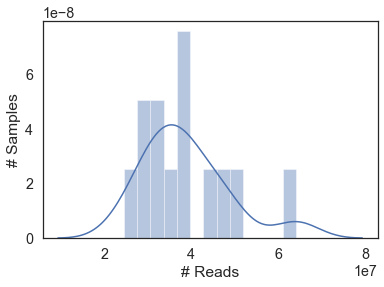

In [14]:
sns.distplot(reads_per_column, bins=13)
plt.xlabel('# Reads')
plt.ylabel('# Samples')

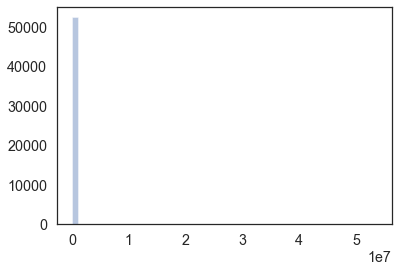

In [15]:
# What is the distribution of reads per gene?
reads_per_gene = df.sum(axis=1)
_ = sns.distplot(reads_per_gene, kde=False)
# Very inflated around 0

In [16]:
df.sum(axis=1).sort_values()
# There is also 1 gene that ate up 53e06 reads, more than 10X any other gene. Let's remove it. 
# It's a lincRNA, dunno why this is the case. Good to keep in mind, dig into why this is the case

Gm28991           0
Gm23010           0
Gm23008           0
Gm23007           0
Gm23005           0
             ...   
mt-Co1      2576748
Actb        2734068
Eef1a1      3075130
Rn7sk       5384406
Gm26917    53572034
Length: 52455, dtype: int64

In [17]:
# We can pull out all indeces that are NOT the one with the highest read count.
everything_but_top_count_gene = df.index.difference([reads_per_gene.idxmax()])
df = df.reindex(everything_but_top_count_gene)

# OR

df.loc[df.sum(axis=1)<53572034]

# OR

df.loc[df.sum(axis=1)!=53572034]

# OR

df.loc[[i for i in df.index if i is not 'Gm26917']]

# The first one is my favorite because it doesn't require copy/pasting or hard coding which can lead to a mistake. 
# HOWEVER everytime you run that line it will remove the gene with the highest count! 
# The last three options can be run any number of times and will only have an effect the first time. 
# When you are doing analysis in a jupyter notebook, this is important to think about, if you over write variables. 

,m1_multipep_001_nat,m1_nopep_001_nat,m1_onexpep_001_nat,m2_multipep_001_nat,m2_nopep_001_nat,m2_onexpep_001_nat,m3_multipep_001_nat,m3_nopep_001_nat,m3_onexpep_001_nat,m4_multipep_001_nat,m4_nopep_001_nat,m4_onexpep_001_nat,m5_multipep_001_nat
0610005C13Rik,1,0,0,7,0,3,2,1,1,11,0,3,9
0610006L08Rik,0,0,0,0,1,0,0,0,1,1,0,0,0
0610009B22Rik,192,146,121,236,79,122,182,151,103,253,120,92,214
0610009E02Rik,54,77,92,76,60,81,46,137,94,128,146,119,104
0610009L18Rik,64,134,145,69,70,176,86,173,193,95,279,323,133
...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s96,0,0,0,0,0,0,0,0,0,0,1,1,1
n-R5s97,0,0,0,0,0,0,0,0,0,0,0,0,0
n-R5s98,0,0,0,0,0,0,0,0,0,0,0,0,0
n-TSaga9,0,3,2,3,0,3,2,7,2,5,2,0,4


Text(0, 0.5, '# samples')

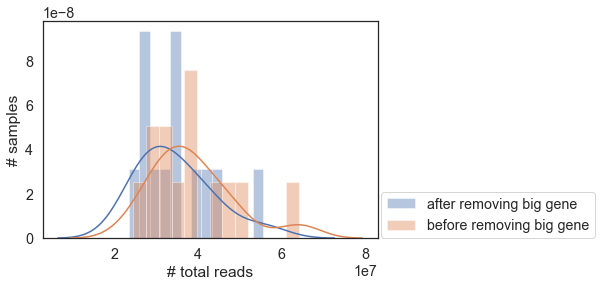

In [18]:
sns.distplot(df.sum(), bins=13, label='after removing big gene')
sns.distplot(reads_per_column, bins=13, label='before removing big gene')
plt.legend(loc=(1.01, 0))
plt.xlabel('# total reads')
plt.ylabel('# samples')

Text(0.5, 0, 'reads before removing big gene')

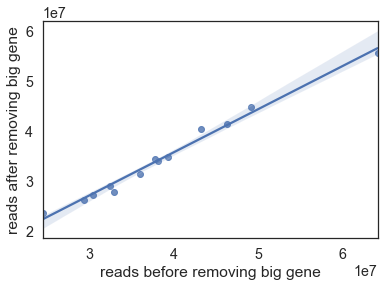

In [19]:
ax = sns.regplot(reads_per_column, df.sum(), )
plt.ylabel('reads after removing big gene')
plt.xlabel('reads before removing big gene')

In [20]:
# Removing any genes that have 0 across the board
df = df.loc[df.sum(axis=1)>0]
df.shape
print('52454 - 27535 = %s genes had 0 counts' % (52454 - 27535))

52454 - 27535 = 24919 genes had 0 counts


Text(0, 0.5, 'Number of genes')

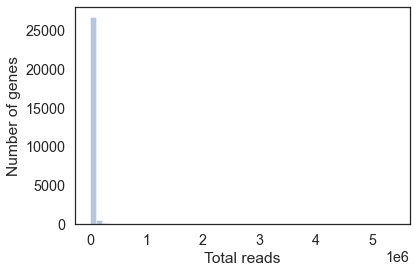

In [21]:
sns.distplot(df.sum(axis=1), kde=False)
plt.xlabel('Total reads')
plt.ylabel('Number of genes')
# Still highly inflated at the low numbers

Text(0, 0.5, 'Number of genes')

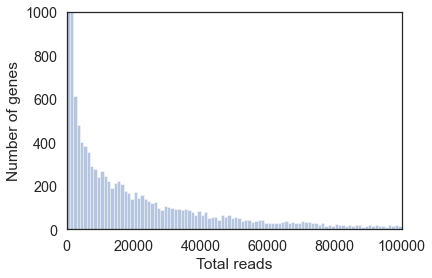

In [22]:
#Lets zoom in
sns.distplot(
    df.sum(axis=1), 
    kde=False, 
    bins=np.arange(0, 100001, 1000)
)
plt.ylim(0, 1000)
plt.xlim(0, 100000)
plt.xlabel('Total reads')
plt.ylabel('Number of genes')

Text(0, 0.5, 'Number of genes')

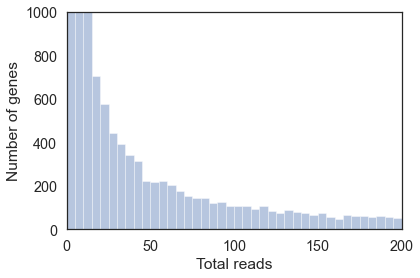

In [23]:
# Lets zoom in even more
sns.distplot(
    df.sum(axis=1), 
    kde=False, 
    bins=np.arange(0, 210, 5)
)
plt.ylim(0, 1000)
plt.xlim(0, 200)
plt.xlabel('Total reads')
plt.ylabel('Number of genes')

/Users/lili/anaconda3/envs/pythonclass/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0, 0.5, '# genes')

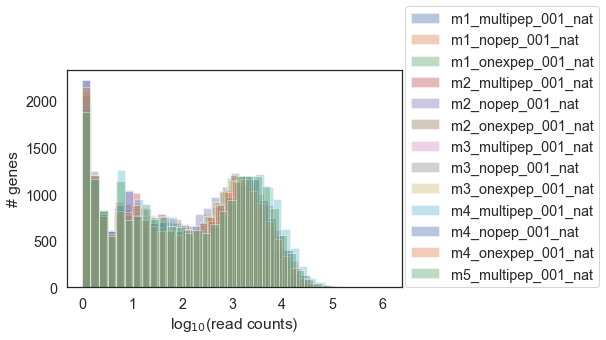

In [24]:
for col_name, col in np.log10(df).replace([np.inf, -np.inf], np.nan).iteritems():
    sns.distplot(col.dropna(), label=col_name, kde=False)
plt.legend(loc=(1.01, 0))
plt.xlabel('log$_{10}$(read counts)')
plt.ylabel('# genes')

Let's remove genes with fewer than 130 reads total (that's an average of ~10 reads per sample)

In [25]:
min_reads = 130
df = df.loc[df.sum(axis=1) > min_reads]

df.shape

(15406, 13)

/Users/lili/anaconda3/envs/pythonclass/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0, 0.5, '# genes')

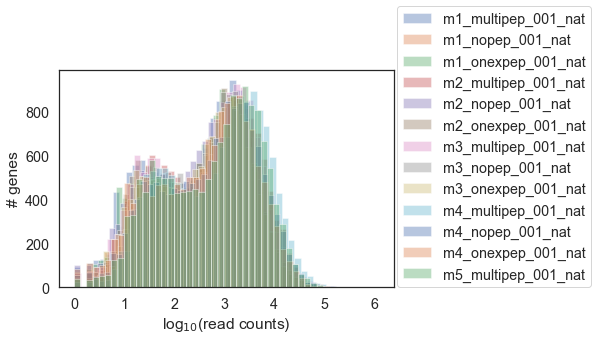

In [26]:
for col_name, col in np.log10(df).replace([np.inf, -np.inf], np.nan).iteritems():
    sns.distplot(col.dropna(), label=col_name, kde=False)
plt.legend(loc=(1.01, 0))
plt.xlabel('log$_{10}$(read counts)')
plt.ylabel('# genes')

Text(0, 0.5, 'Number of samples')

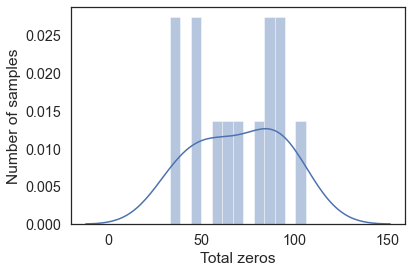

In [27]:
# Let's check for number of 0s per sample and per gene

zeros_per_sample = (df == 0).sum()
zeros_per_gene = (df == 0).sum(axis=1)

sns.distplot(zeros_per_sample, bins=13)
plt.xlabel('Total zeros')
plt.ylabel('Number of samples')
# Ends up as very compared to the number of genes, so we'll let it all go. 

Text(0, 0.5, 'Number of genes')

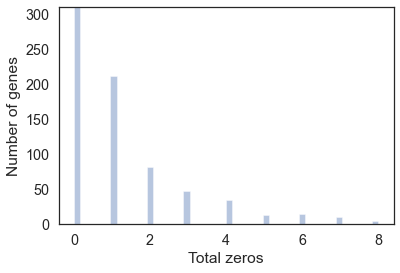

In [28]:
sns.distplot(zeros_per_gene, kde=False)
plt.ylim(0, 310)
plt.xlabel('Total zeros')
plt.ylabel('Number of genes')

In [29]:
# Let's filter for genes that are non-zero in at least 4 samples

df = df.loc[(df==0).sum(axis=1) < 9]

# OR

df.loc[(df!=0).sum(axis=1) >= 4]

# OR

df.replace(0, np.nan).dropna(thresh=4)

# non-missing values to keep. It is the number of non-missing values required. 
# All of these can be run more than once with no effect. 
# The last one introduces NAs which is bad for machine learning, so let's not use that one right now. 

,m1_multipep_001_nat,m1_nopep_001_nat,m1_onexpep_001_nat,m2_multipep_001_nat,m2_nopep_001_nat,m2_onexpep_001_nat,m3_multipep_001_nat,m3_nopep_001_nat,m3_onexpep_001_nat,m4_multipep_001_nat,m4_nopep_001_nat,m4_onexpep_001_nat,m5_multipep_001_nat
0610009B22Rik,192.0,146.0,121.0,236.0,79.0,122.0,182.0,151.0,103.0,253.0,120.0,92.0,214.0
0610009E02Rik,54.0,77.0,92.0,76.0,60.0,81.0,46.0,137.0,94.0,128.0,146.0,119.0,104.0
0610009L18Rik,64.0,134.0,145.0,69.0,70.0,176.0,86.0,173.0,193.0,95.0,279.0,323.0,133.0
0610009O20Rik,1075.0,979.0,836.0,1198.0,636.0,1055.0,1445.0,1076.0,986.0,2008.0,1614.0,1429.0,1940.0
0610010F05Rik,886.0,819.0,541.0,2377.0,793.0,695.0,1191.0,749.0,569.0,2116.0,1139.0,855.0,1728.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
mt-Tp,214.0,408.0,434.0,569.0,473.0,410.0,277.0,586.0,435.0,261.0,428.0,359.0,224.0
mt-Tr,31.0,8.0,5.0,48.0,22.0,24.0,8.0,11.0,14.0,10.0,NaN,NaN,NaN
mt-Tt,21.0,15.0,14.0,26.0,12.0,6.0,8.0,15.0,8.0,21.0,15.0,12.0,10.0
mt-Tw,59.0,58.0,66.0,54.0,48.0,50.0,29.0,81.0,41.0,43.0,55.0,26.0,49.0


# Normalization and pre-processing

We have to correct for different coverage in different samples. 

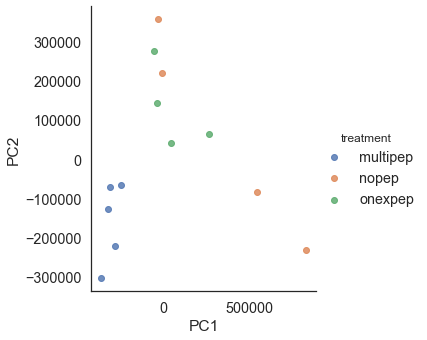

In [37]:
pca = decomposition.PCA(n_components=2)
pca_transformed = pca.fit_transform(df.transpose())
pca_transformed = pd.DataFrame(pca_transformed, index=df.columns, columns=['PC1', 'PC2'])
pca_transformed = pd.concat([pca_transformed, exp_design], axis=1)

sns.lmplot(x='PC1', y='PC2', data=pca_transformed, hue='treatment', fit_reg=False)

### Let's decide how to normalize samples

In [40]:
from sklearn import preprocessing
import scipy.stats

### Sample/column distribution

Text(0, 0.5, '# genes')

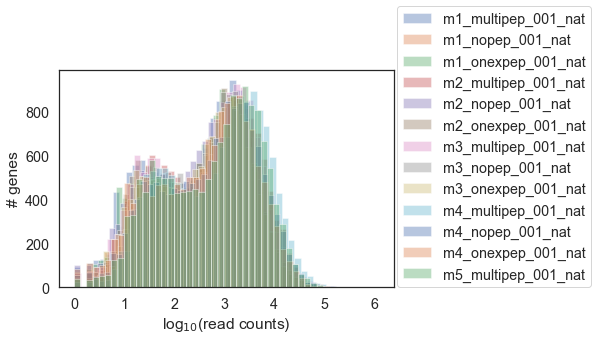

In [31]:
for col_name, col in np.log10(df).replace([np.inf, -np.inf], np.nan).iteritems():
    sns.distplot(col.dropna(), label=col_name, kde=False)
plt.legend(loc=(1.01, 0))
plt.xlabel('log$_{10}$(read counts)')
plt.ylabel('# genes')

In [42]:
def column_normalize(df, method):
    if method == 'count_per_k':
        return df.divide(df.sum())*1000
        
    if method == 'median':
        return df.divide(df.median())
    
    if method == 'median_of_ratios':
        ratios = df.divide(df.mean(axis=1), axis=0)
        return df.divide(ratios.median())
    
    if method == 'quantile':
        temp = preprocessing.quantile_transform(
            df, n_quantiles=len(df), output_distribution='normal', copy=True
        )
        temp = pd.DataFrame(temp, index=df.index, columns=df.columns)
        return temp

### Normalizing for sample coverage

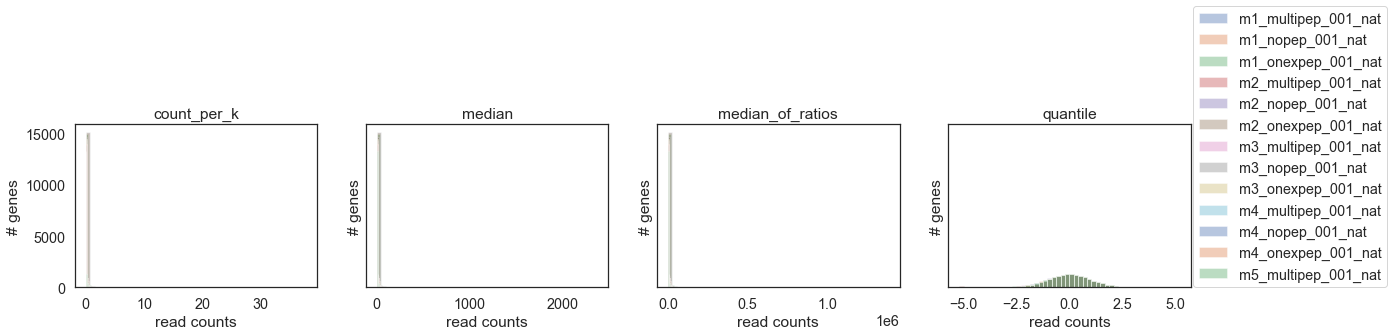

In [33]:
methods = ['count_per_k', 'median', 'median_of_ratios', 'quantile']

fig, axs = plt.subplots(ncols=4, figsize=(20, 3), sharey=True)

for i, method in enumerate(methods):
    ax = axs[i]
    normed = column_normalize(df, method)
    
    for col_name, col in normed.iteritems():
        sns.distplot(col.dropna(), label=col_name, kde=False, ax=ax)
    ax.set_title(method)
    
    ax.set_xlabel('read counts')
    ax.set_ylabel('# genes')
# plt.xlim(-2, 2)
plt.legend(loc=(1.01, 0))
plt.show()
plt.close()

/Users/lili/anaconda3/envs/pythonclass/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()
/Users/lili/anaconda3/envs/pythonclass/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log2
  app.launch_new_instance()


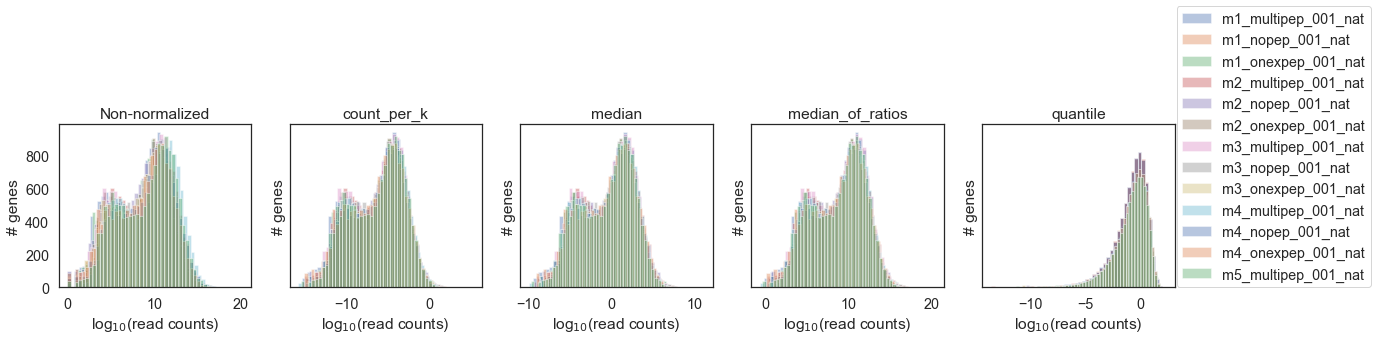

In [34]:
methods = ['count_per_k', 'median', 'median_of_ratios', 'quantile']

fig, axs = plt.subplots(ncols=5, figsize=(20, 3), sharey=True)

ax = axs[0]
for col_name, col in np.log2(df).replace([np.inf, -np.inf], np.nan).iteritems():
    sns.distplot(col.dropna(), label=col_name, kde=False, ax=ax)
ax.set_title('Non-normalized')
ax.set_xlabel('log$_{10}$(read counts)')
ax.set_ylabel('# genes')
    
for i, method in enumerate(methods):
    ax = axs[i+1]
    normed = column_normalize(df, method)
    
    for col_name, col in np.log2(normed).replace([np.inf, -np.inf], np.nan).iteritems():
        sns.distplot(col.dropna(), label=col_name, kde=False, ax=ax)
    ax.set_title(method)
    
    ax.set_xlabel('log$_{10}$(read counts)')
    ax.set_ylabel('# genes')
# plt.xlim(-2, 2)
plt.legend(loc=(1.01, 0))
plt.show()
plt.close()

/Users/lili/anaconda3/envs/pythonclass/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log2
  app.launch_new_instance()
/Users/lili/anaconda3/envs/pythonclass/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log2
  app.launch_new_instance()


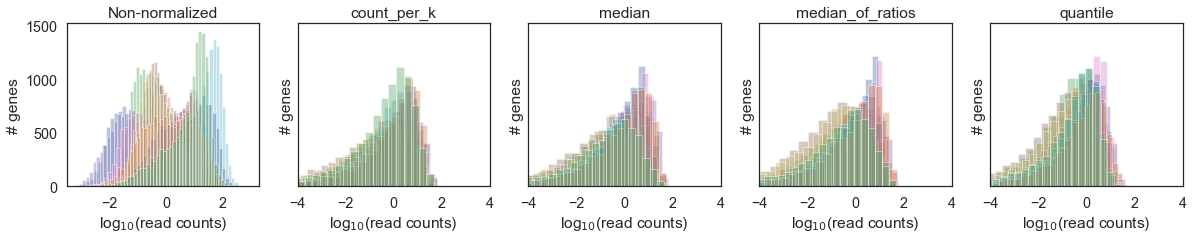

In [35]:
methods = ['count_per_k', 'median', 'median_of_ratios', 'quantile']

fig, axs = plt.subplots(ncols=5, figsize=(20, 3), sharey=True)

ax = axs[0]
for col_name, col in pd.DataFrame(scipy.stats.zscore(np.log2(df).replace([np.inf, -np.inf], np.nan), axis=1, nan_policy='omit')).iteritems():
    sns.distplot(col.dropna(), label=col_name, kde=False, ax=ax)
ax.set_title('Non-normalized')
ax.set_xlabel('log$_{10}$(read counts)')
ax.set_ylabel('# genes')
    
for i, method in enumerate(methods):
    ax = axs[i+1]
    normed = pd.DataFrame(scipy.stats.zscore(column_normalize(df, method), axis=1, nan_policy='omit'))
    
    for col_name, col in np.log2(normed).replace([np.inf, -np.inf], np.nan).iteritems():
        sns.distplot(col.dropna(), kde=False, ax=ax)
    ax.set_title(method)
    
    ax.set_xlabel('log$_{10}$(read counts)')
    ax.set_ylabel('# genes')
    ax.set_xlim(-4, 4)

plt.show()
plt.close()

Let's go forward with z-scored quantile normalization. 

In [43]:
normed = pd.DataFrame(
    scipy.stats.zscore(column_normalize(df, 'quantile'), axis=1, nan_policy='omit'),
    index=df.index,
    columns=df.columns
)

### Let's check the PCA again, see if normalization helped the replicate grouping

Text(51.15087406944444, 0.5, 'PC1 - 0.17 explained variance')

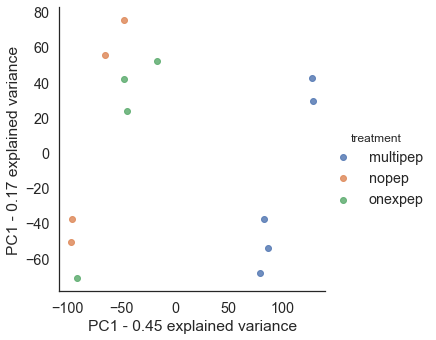

In [50]:
pca = decomposition.PCA(n_components=2)
pca_transformed = pca.fit_transform(normed.transpose())
pca_transformed = pd.DataFrame(pca_transformed, index=df.columns, columns=['PC1', 'PC2'])
pca_transformed = pd.concat([pca_transformed, exp_design], axis=1)

sns.lmplot(x='PC1', y='PC2', data=pca_transformed, hue='treatment', fit_reg=False)
plt.xlabel('PC1 - %.2f explained variance'  % pca.explained_variance_ratio_[0])
plt.ylabel('PC1 - %.2f explained variance'  % pca.explained_variance_ratio_[1])

## This looks really good! 45% of the variance on PC1 is between the groups we want to compare. The two control groups are co-mingling
### My guess is that PC1 represents batchs, but we would need more meta data to figure that out. 

# Let's run some tests!

In [44]:
treatment_groups = exp_design.groupby('treatment').groups
treatment_groups

{'multipep': Index(['m1_multipep_001_nat', 'm2_multipep_001_nat', 'm3_multipep_001_nat',
        'm4_multipep_001_nat', 'm5_multipep_001_nat'],
       dtype='object'),
 'nopep': Index(['m1_nopep_001_nat', 'm2_nopep_001_nat', 'm3_nopep_001_nat',
        'm4_nopep_001_nat'],
       dtype='object'),
 'onexpep': Index(['m1_onexpep_001_nat', 'm2_onexpep_001_nat', 'm3_onexpep_001_nat',
        'm4_onexpep_001_nat'],
       dtype='object')}

In [51]:
vs_onexpep = pd.DataFrame()
vs_onexpep[['t-stat', 'pvalue']] = normed.apply(
    lambda row: pd.Series(scipy.stats.ttest_ind(
        row[treatment_groups['multipep']],
        row[treatment_groups['onexpep']]
    )),
    axis=1
)
vs_onexpep.head()

,t-stat,pvalue
0610009B22Rik,2.676199,0.031713
0610009E02Rik,-4.427686,0.003053
0610009L18Rik,-6.008592,0.000538
0610009O20Rik,-0.157779,0.879086
0610010F05Rik,3.582954,0.008941
...,...,...
mt-Tp,-2.382240,0.048721
mt-Tr,NaN,NaN
mt-Tt,0.690818,0.511930
mt-Tw,-0.598993,0.568048


In [52]:
vs_nopep = pd.DataFrame()
vs_nopep[['t-stat', 'pvalue']] = normed.apply(
    lambda row: pd.Series(scipy.stats.ttest_ind(
        row[treatment_groups['multipep']],
        row[treatment_groups['nopep']]
    )),
    axis=1
)
vs_nopep.head()

,t-stat,pvalue
0610009B22Rik,2.740047,0.028916
0610009E02Rik,-2.106845,0.073128
0610009L18Rik,-2.912729,0.022573
0610009O20Rik,0.909216,0.393464
0610010F05Rik,1.868631,0.103887


In [60]:
results = {
    'onexpep': vs_onexpep,
    'nopep': vs_nopep
}

for df in results.values():
    df['FDR'] = (df['pvalue']*len(df)).clip(upper=1.)
    
    df['signedFDR'] = -np.log10(df['FDR']) * (df['t-stat']/df['t-stat'].abs())

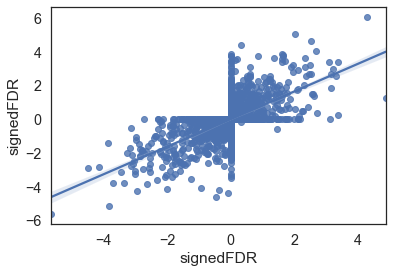

In [62]:
sns.regplot(
    results['onexpep']['signedFDR'],
    results['nopep']['signedFDR']
)